_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [237]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas_profiling

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [238]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,  plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [239]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)
# YOUR CODE HERE

print(df.shape)
df

(13958, 20)


,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0
13954,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0
13955,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0


In [240]:
type(df.index)

pandas.core.indexes.range.RangeIndex

In [241]:
df['shot_type'].value_counts()

2PT Field Goal    7135
3PT Field Goal    6823
Name: shot_type, dtype: int64

In [242]:
df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'game_date', 'htm', 'vtm',
       'season_type', 'scoremargin_before_shot'],
      dtype='object')

In [243]:
def wrangle(url):
  df = pd.read_csv(url, parse_dates = ['game_date'])

#delete constant columns
  constant_columns = [col for col in df.columns if df[col].nunique() ==1]
  df = df.drop(columns=constant_columns)

#turn binary string columns into binary numerical columns
  df['shot_type'] = np.where(df['shot_type'] == '2PT Field Goal', 0, 1)
  df['season_type'] = np.where(df['season_type'] == 'Regular Season', 0, 1)

#represent shot zones with numerical values (ordinal encoding can accomplish this also)  
  df['shot_zone_range'].replace({'Less Than 8 ft.':'1','8-16 ft.':'2','16-24 ft.':'3',
                                 '24+ ft.':'4','Back Court Shot':'5'}, inplace=True)

#change converted string columns dtypes  
  df['shot_type'].astype(int)
  df['season_type'].astype(int)
  df['shot_zone_range'].astype(int)

#Engineered columns
  df['tot_period_sec_remaining'] = df['minutes_remaining']*60 +df['seconds_remaining']
  df['game_year'] = df.game_date.dt.year
  df['game_month'] = df.game_date.dt.month
  df['game_day'] = df.game_date.dt.day

#index date column
  df.set_index('game_date', inplace=True)

  return df

df = wrangle(url)


print(df.shape)
df

(13958, 22)


,game_id,game_event_id,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,tot_period_sec_remaining,game_year,game_month,game_day
game_date,,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,1,11,25,Jump Shot,1,Above the Break 3,Right Side Center(RC),4,26,99,249,0,GSW,HOU,0,2.0,685,2009,10,28
2009-10-28,20900015,17,1,9,31,Step Back Jump shot,0,Mid-Range,Left Side Center(LC),3,18,-122,145,1,GSW,HOU,0,0.0,571,2009,10,28
2009-10-28,20900015,53,1,6,2,Jump Shot,0,In The Paint (Non-RA),Center(C),2,14,-60,129,0,GSW,HOU,0,-4.0,362,2009,10,28
2009-10-28,20900015,141,2,9,49,Jump Shot,0,Mid-Range,Left Side(L),3,19,-172,82,0,GSW,HOU,0,-4.0,589,2009,10,28
2009-10-28,20900015,249,2,2,19,Jump Shot,0,Mid-Range,Left Side Center(LC),3,16,-68,148,0,GSW,HOU,0,0.0,139,2009,10,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-05,41800403,570,4,8,1,Pullup Jump shot,0,In The Paint (Non-RA),Center(C),2,12,3,120,1,GSW,TOR,1,-13.0,481,2019,6,5
2019-06-05,41800403,573,4,7,16,Floating Jump shot,0,Mid-Range,Right Side(R),2,11,114,-5,0,GSW,TOR,1,-14.0,436,2019,6,5
2019-06-05,41800403,602,4,5,27,Step Back Jump shot,1,Above the Break 3,Left Side Center(LC),4,26,-217,149,0,GSW,TOR,1,-17.0,327,2019,6,5


In [244]:
#Report = ProfileReport(df, minimal=True).to_notebook_iframe()

In [245]:
df.dtypes

game_id                       int64
game_event_id                 int64
period                        int64
minutes_remaining             int64
seconds_remaining             int64
action_type                  object
shot_type                     int64
shot_zone_basic              object
shot_zone_area               object
shot_zone_range              object
shot_distance                 int64
loc_x                         int64
loc_y                         int64
shot_made_flag                int64
htm                          object
vtm                          object
season_type                   int64
scoremargin_before_shot     float64
tot_period_sec_remaining      int64
game_year                     int64
game_month                    int64
game_day                      int64
dtype: object

**Task 1 Testing**

In [246]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [247]:
"""T2. Create new feature"""

# added to wrangle above

#df['game_year'] = df.game_date.dt.year
#df['game_month'] = df.game_date.dt.month
#df['game_day'] = df.game_date.dt.day

'T2. Create new feature'

In [248]:
#multiply minutes_remaining by 60 to retrieve seconds per minutes and then 
#add that to seconds_remaining to get total seconds remaining in the period
df['tot_period_sec_remaining'] = 60*df['minutes_remaining'] + df['seconds_remaining']
df['tot_period_sec_remaining']

game_date
2009-10-28    685
2009-10-28    571
2009-10-28    362
2009-10-28    589
2009-10-28    139
             ... 
2019-06-05    481
2019-06-05    436
2019-06-05    327
2019-06-05    290
2019-06-05    167
Name: tot_period_sec_remaining, Length: 13958, dtype: int64

**Task 2 Test**

In [249]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [250]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
target = 'shot_made_flag'
y = df['shot_made_flag']
X = df.drop(columns='shot_made_flag')

**Task 3 Test**

In [251]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [252]:
'''T4. Create training and val'''
# create three date-time masks to split data into training/val/test 
mask_val = (X.index > pd.to_datetime('2017-09')) & (X.index < pd.to_datetime('2018-07'))
mask_train = (X.index < pd.to_datetime('2017-09'))
mask_test = (X.index > pd.to_datetime('2018-07'))

X_train, y_train = X[mask_train], y[mask_train]
X_val, y_val = X[mask_val], y[mask_val]
X_test, y_test = X[mask_test], y[mask_test]

In [253]:
len(X)

13958

In [254]:
len(X_val)

1168

**Test 4**

In [255]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [256]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [257]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [258]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# Create pipeline with OrdinalEncoder because we want to keep one of our columns that has >50 subclasses
# Use StandardScaler to help data look like standard normally distrubuted data

model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(n_estimators=100,
                           max_depth = 10,
                           n_jobs=-1,
                           random_state=42)
)

model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_zone_basic',
                                      'shot_zone_area', 'shot_zone_range',
                                      'htm', 'vtm'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving La...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_

**Task 6 Testing**

In [259]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [260]:
'''T7. Calculate train and test accuracy.'''


train_acc = model.score(X_train,y_train)
val_acc = model.score(X_val,y_val)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.7571518815991336
Validation Accuracy Score: 0.6078767123287672


**Task 7 Test**

In [261]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [274]:
'''T8. Tune model.'''

# YOUR CODE HERE
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1,bootstrap=True,max_depth=10,
                           max_features='auto',n_estimators=100, criterion='gini',
                           min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, min_impurity_split=None, 
                           oob_score=False, verbose=0, warm_start=False, 
                           class_weight=None, ccp_alpha=0.0, max_samples=None)
)


param_grid = {
    'simpleimputer__strategy': ['median'],
    'randomforestclassifier__max_depth': range(10, 40, 10),
    'randomforestclassifier__n_estimators': range(50, 125, 50)
}

model_rs = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=None,
    verbose=1,
    n_iter = 3
)

model_rs.fit(X,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   18.6s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=Non

In [275]:
model_rs.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'median'}

In [276]:
model_rs.best_score_

0.6401357874625664

In [277]:
test_acc = model_rs.score(X_test,y_test)

print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.7788180222352252


**Task 8 Testing**

In [266]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

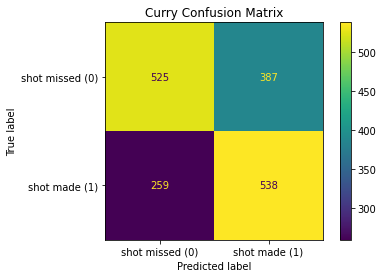

In [267]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538/(538+259)
instructor_recall = 538/(538+387)

print('Instuctor model precision:', instructor_precision)
print('Instuctor model recall:', instructor_recall)

Instuctor model precision: 0.6750313676286073
Instuctor model recall: 0.5816216216216217


**Task 9 Testing**

In [268]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

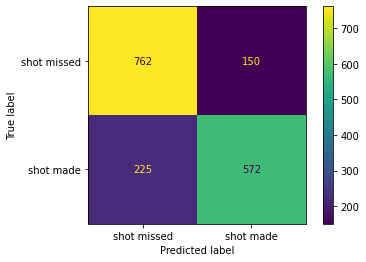

In [269]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE

plot_confusion_matrix(
    model_rs,
    X_test,
    y_test,
    values_format = '.0f',
    display_labels = ['shot missed', 'shot made']
)

Both the True Positives and the True Negatives increased; while both False Negatives and False Positives decreased. This created a resulting higher precision, higher recall and a more accurate show casing of a confusion matrix.



In [278]:
New_precision = 538/(538+225)
New_recall = 538/(538+150)

print('New model precision:', New_precision)
print('New model recall:', New_recall)

New model precision: 0.7051114023591087
New model recall: 0.7819767441860465


In [279]:
New_precision - instructor_precision

0.03008003473050147

In [280]:
New_recall - instructor_recall

0.20035512256442478

New_precision increased by 0.0301 when compared to the earlier instructor_precision.


New_recall increased by 0.2004 when compared to the earlier instructor_recall